### Compound V2 Wallet Risk Scoring Script (End-to-End)

In [ ]:
import requests
import pandas as pd
from tqdm import tqdm
import time

# Set your Moralis API Key here
MORALIS_API_KEY = "Put your Moralis API Key here"  
HEADERS = {
    "accept": "application/json",
    "X-API-Key": MORALIS_API_KEY
}

# Load wallet list
wallets_df = pd.read_csv("data/Wallet id - Sheet1.csv")
wallets = wallets_df['wallet_id'].tolist()

# Fetch transaction history from Moralis API
def fetch_transactions(wallet, chain="eth", limit=100):
    url = f"https://deep-index.moralis.io/api/v2.2/{wallet}/erc20/transfers?chain={chain}&limit={limit}"
    try:
        response = requests.get(url, headers=HEADERS)
        if response.status_code == 200:
            return response.json().get("result", [])
        else:
            print(f"Failed for {wallet} → Status Code: {response.status_code}")
            return []
    except Exception as e:
        print(f"Error: {e}")
        return []

# ---------------------------Feature engineering------------------------
def extract_features(transactions):
    features = {
        "num_transactions": len(transactions),
        "unique_tokens": 0,
        "total_amount": 0,
        "avg_value": 0,
        "recent_txn_days": 0
    }

    if not transactions:
        return features

    token_addresses = set()
    total_value = 0
    timestamps = []

    for tx in transactions:
        token_addr = tx.get("token_address")
        if token_addr:
            token_addresses.add(token_addr)

        try:
            total_value += float(tx.get("value", 0)) / 1e18
        except Exception:
            pass

        if "block_timestamp" in tx:
            try:
                dt = pd.to_datetime(tx["block_timestamp"])
                timestamps.append(dt)
            except Exception:
                pass

    features["unique_tokens"] = len(token_addresses)
    features["total_amount"] = total_value
    features["avg_value"] = total_value / features["num_transactions"] if features["num_transactions"] > 0 else 0

    if timestamps:
        most_recent = max(timestamps)
        features["recent_txn_days"] = (pd.Timestamp.utcnow() - most_recent).days

    return features


# --------------------------Score computation---------------------------
def compute_score(features_df):
    normed = (features_df - features_df.min()) / (features_df.max() - features_df.min() + 1e-9)
    score = (
        normed["num_transactions"] * 2 +
        normed["unique_tokens"] * 1.5 +
        normed["total_amount"] * 2.5 +
        normed["avg_value"] * 1 +
        (1 - normed["recent_txn_days"]) * 2
    )
    scaled = 1000 * (score - score.min()) / (score.max() - score.min() + 1e-9)
    return scaled.clip(0, 1000).round(0).astype(int)

# Main loop
features_list = []

for wallet in tqdm(wallets):
    txns = fetch_transactions(wallet)
    features = extract_features(txns)
    features["wallet"] = wallet
    features_list.append(features)
    time.sleep(0.2)  # Avoid hitting API limits



100%|██████████| 103/103 [01:22<00:00,  1.25it/s]


In [ ]:
# -------------------Save features and scores------------------------
features_df = pd.DataFrame(features_list)
features_df.to_csv("wallet_features.csv", index=False)
features_df["score"] = compute_score(features_df.drop(columns=["wallet"]))
features_df[["wallet", "score"]].rename(columns={"wallet": "wallet_id"}).to_csv("wallet_scores.csv", index=False)


✅ All done! Check wallet_features.csv and wallet_scores.csv


In [ ]:
# Loaded raw features and applied log transformation to 'total_amount'

import pandas as pd
import numpy as np

# Load existing wallet features
df = pd.read_csv("wallet_features.csv")

# Replace zero/negative with small value to prevent log(0)
df['log_total_amount'] = np.log1p(df['total_amount'])

# Save updated features
df.to_csv("wallet_features_updated.csv", index=False)

# Show a preview
df[['wallet', 'total_amount', 'log_total_amount']].head()

#  Define scoring function using log_total_amount

def score_wallets(df):
    df = df.copy()
    
    # Normalization helper
    norm = lambda col: (col - col.min()) / (col.max() - col.min() + 1e-9)
    
    df['score'] = 0

    weights = {
        'num_transactions': 2.0,
        'unique_tokens': 1.5,
        'log_total_amount': 1.5,
        'avg_value': 1.0,
        'recent_txn_days': -1.0
    }

    for col, w in weights.items():
        if col in df.columns:
            df['score'] += w * norm(df[col])

    df['score'] = 1000 * norm(df['score'])
    return df[['wallet', 'score']].round(0).astype({'score': int})

#  Generate and save scores

scores = score_wallets(df)
scores.to_csv("wallet_scores_updated.csv", index=False)

print("✅ Updated scores saved to wallet_scores_updated.csv")
scores.head()


✅ Updated scores saved to wallet_scores_updated.csv


,wallet,score
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,615
1,0x06b51c6882b27cb05e712185531c1f74996dd988,36
2,0x0795732aacc448030ef374374eaae57d2965c16c,40
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,470
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,37


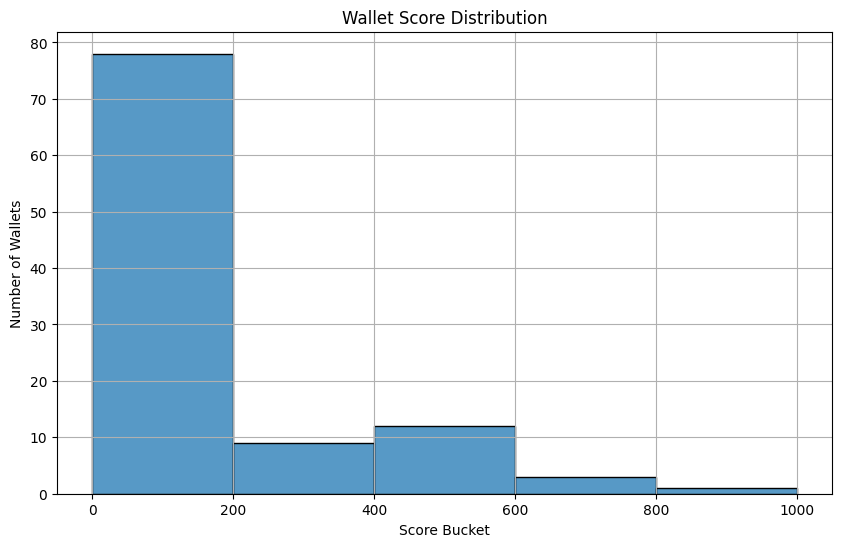

Number of wallets with score = 0: 1
Number of wallets with score = 1000: 1

🎯 Top 3 wallets:
                                        wallet  score  num_transactions  \
75  0xa7f3c74f0255796fd5d3ddcf88db769f7a6bf46a   1000               100   
80  0xbd4a00764217c13a246f86db58d74541a0c3972a    628               100   
0   0x0039f22efb07a647557c7c5d17854cfd6d489ef3    615               100   

    unique_tokens  total_amount     avg_value  recent_txn_days  \
75              0  2.291033e+31  2.291033e+29              496   
80              0  6.951397e+06  6.951397e+04                4   
0               0  5.442950e+05  5.442950e+03               39   

                                        wallet  
75  0xa7f3c74f0255796fd5d3ddcf88db769f7a6bf46a  
80  0xbd4a00764217c13a246f86db58d74541a0c3972a  
0   0x0039f22efb07a647557c7c5d17854cfd6d489ef3  

⚠️ Bottom 3 wallets:
                                        wallet  score  num_transactions  \
74  0xa7e94d933eb0c439dda357f61244a485246e97b8  

In [23]:
## --------------Visualize Score Distribution -------------------

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load CSVs
scores_df = pd.read_csv("wallet_scores_updated.csv")
features_df = pd.read_csv("wallet_features_updated.csv")

# ✅ Fix column name mismatch before merging
scores_df.rename(columns={'wallet_id': 'wallet'}, inplace=True)

# Merge on wallet address
df = pd.merge(features_df, scores_df, on='wallet')

# Score distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['score'], bins=[0, 200, 400, 600, 800, 1000], kde=False)
plt.title("Wallet Score Distribution")
plt.xlabel("Score Bucket")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.savefig("score_distribution_analysis.png")
plt.show()

# Outlier check
print("Number of wallets with score = 0:", (df['score'] == 0).sum())
print("Number of wallets with score = 1000:", (df['score'] == 1000).sum())

# Top 3 wallets
print("\n🎯 Top 3 wallets:")
print(df.sort_values(by='score', ascending=False).head(3)[['wallet', 'score'] + list(features_df.columns[:-1])])

# Bottom 3 wallets
print("\n⚠️ Bottom 3 wallets:")
print(df.sort_values(by='score').head(3)[['wallet', 'score'] + list(features_df.columns[:-1])])